# Bayesian lasso logistic regresison

In [145]:
# import package
import arviz as az
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pymc as pm
import pymc.math as pmath
import pandas as pd
from sklearn.metrics import RocCurveDisplay, auc, roc_curve


In [146]:
# load dataset 
df = pd.read_csv('diabetes_imputed_CE.csv')
# drop the first col which is the same as id col
df = df.drop(df.columns[0], axis=1)
df.head(10) # head of the data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.00000,35.000000,208.169083,33.600000,0.627,50,1
1,1,85.0,66.00000,29.000000,157.620259,26.600000,0.351,31,0
2,8,183.0,64.00000,29.522514,146.807322,23.300000,0.672,32,1
3,1,89.0,66.00000,23.000000,94.000000,28.100000,0.167,21,0
4,0,137.0,40.00000,35.000000,168.000000,43.100000,2.288,33,1
5,5,116.0,74.00000,28.313905,131.672830,25.600000,0.201,30,0
6,3,78.0,50.00000,32.000000,88.000000,31.000000,0.248,26,1
7,10,115.0,72.55654,29.083141,113.938668,35.300000,0.134,29,0
8,2,197.0,70.00000,45.000000,543.000000,30.500000,0.158,53,1
9,8,125.0,96.00000,33.285207,213.104630,32.060241,0.232,54,1


In [172]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.670300,72.371121,29.199634,158.749804,32.456407,0.471876,33.240885
std,3.369578,30.439049,12.116049,8.824640,88.954459,6.877164,0.331329,11.760232
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000
25%,1.000000,99.750000,64.000000,25.000000,118.209846,27.500000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,29.094191,144.264773,32.159336,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.287443,183.020372,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [148]:
X = df.astype(float)
y = df.pop("Outcome")
# standardize the predictors
# after standardizing, the convergence looks much better
X -= X.mean()
X /= X.std()

In [149]:
X = X.drop(['Outcome'], axis=1)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639530,0.864997,-0.030631,0.657292,0.555557,0.166288,0.468187,1.425067
1,-0.844335,-1.204712,-0.525841,-0.022622,-0.012698,-0.851573,-0.364823,-0.190548
2,1.233077,2.014836,-0.690912,0.036588,-0.134254,-1.331422,0.604004,-0.105515
3,-0.844335,-1.073302,-0.525841,-0.702537,-0.727898,-0.633460,-0.920163,-1.040871
4,-1.141108,0.503620,-2.671755,0.657292,0.103988,1.547672,5.481337,-0.020483


In [150]:
y.head(10)

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

## Lasso for variables selection

D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


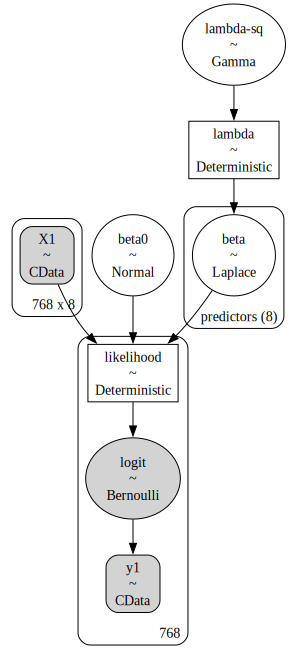

In [151]:
with pm.Model(coords={"predictors": X.columns.values}) as lasso_logistic_model:

    X1 = pm.MutableData("X1", X)
    y1 = pm.MutableData("y1", y)
    # 
    # lambda parameter for the lasso lambda ~ gamma(1,1)
    lambda_sq = pm.Gamma('lambda-sq', alpha=1, beta=1)
    lambda_param = pm.Deterministic('lambda', pmath.sqrt(lambda_sq))
    #lambda_param = pm.Gamma('lambda', alpha=1, beta=1)

    # intercept ~ normal(0,sd=100) - an uninformative prior
    # all the rest betas follow Laplacee dist wiht mu=0, and scale = lambda which follows a gamma(1,1)
    beta0 = pm.Normal('beta0', 0, sigma=100)
    beta = pm.Laplace('beta', mu=0, b=1/lambda_param, dims = "predictors")
   # beta2 = pymc.Laplace('beta1', mu=0, b=lambda_param)
   # beta3= pymc.Laplace('beta1', mu=0, b=lambda_param)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.Deterministic("likelihood", pm.math.invlogit(beta0 + pm.math.dot(X1, beta)) )

    # Bernoulli random vector with probability of success
    # given by inverseee-logit function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=y1)
pm.model_to_graphviz(lasso_logistic_model)

In [152]:
# posterior sampling
with lasso_logistic_model:
    trace = pm.sample(10000, chains = 4, random_seed=2024, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda-sq, beta0, beta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 43 seconds.


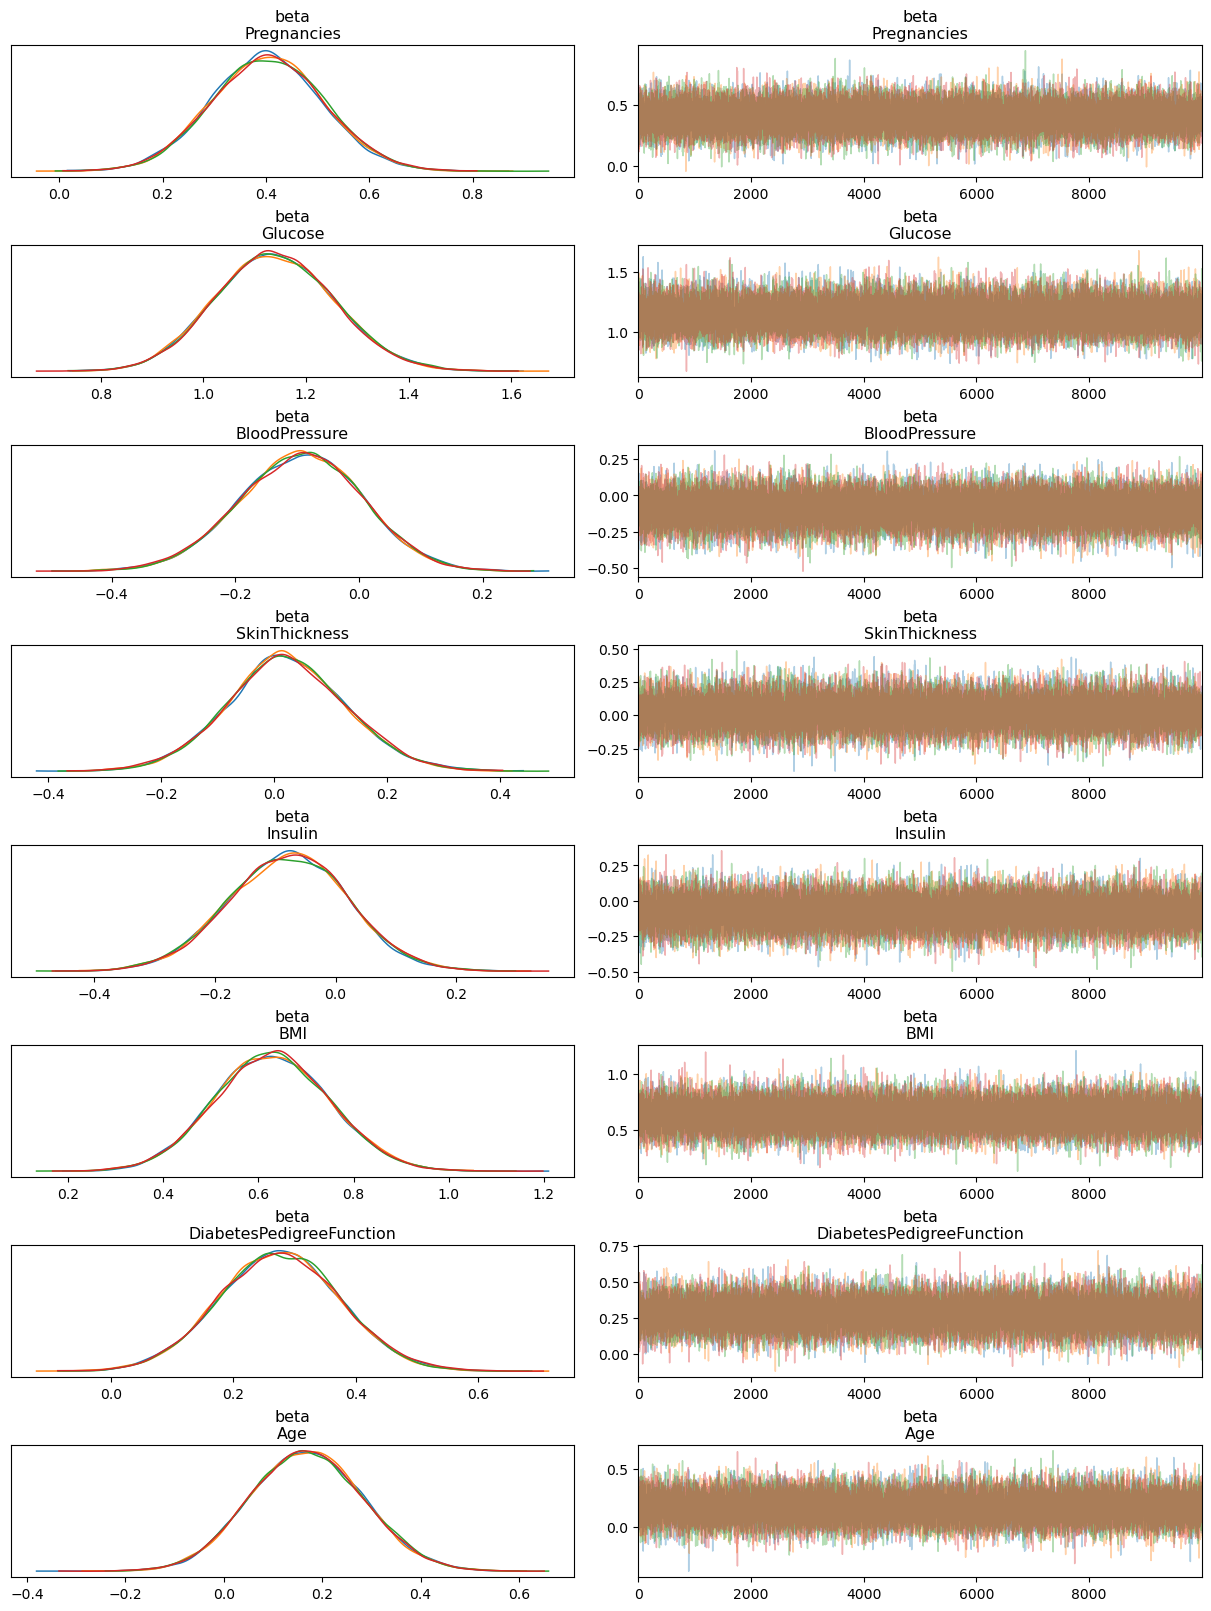

In [153]:
az.plot_trace(trace, var_names="beta", compact=False)
plt.rcParams['figure.constrained_layout.use'] = True

In [169]:
az.summary(trace, hdi_prob = 0.95, var_names="beta")

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[Pregnancies],0.403,0.109,0.198,0.624,0.000,0.000,55828.0,34703.0,1.0
beta[Glucose],1.141,0.116,0.910,1.362,0.000,0.000,54112.0,33342.0,1.0
beta[BloodPressure],-0.094,0.100,-0.286,0.105,0.000,0.000,55891.0,32872.0,1.0
beta[SkinThickness],0.022,0.107,-0.193,0.229,0.000,0.001,50215.0,31017.0,1.0
beta[Insulin],-0.078,0.100,-0.278,0.114,0.000,0.000,54822.0,33396.0,1.0
beta[BMI],0.629,0.121,0.394,0.866,0.001,0.000,47387.0,31481.0,1.0
beta[DiabetesPedigreeFunction],0.275,0.099,0.079,0.465,0.000,0.000,62104.0,31843.0,1.0
beta[Age],0.169,0.114,-0.054,0.391,0.001,0.000,52189.0,33239.0,1.0


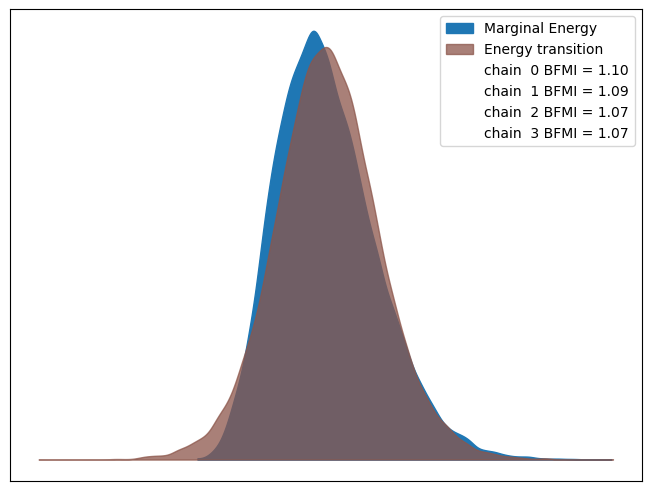

In [155]:
az.plot_energy(trace);

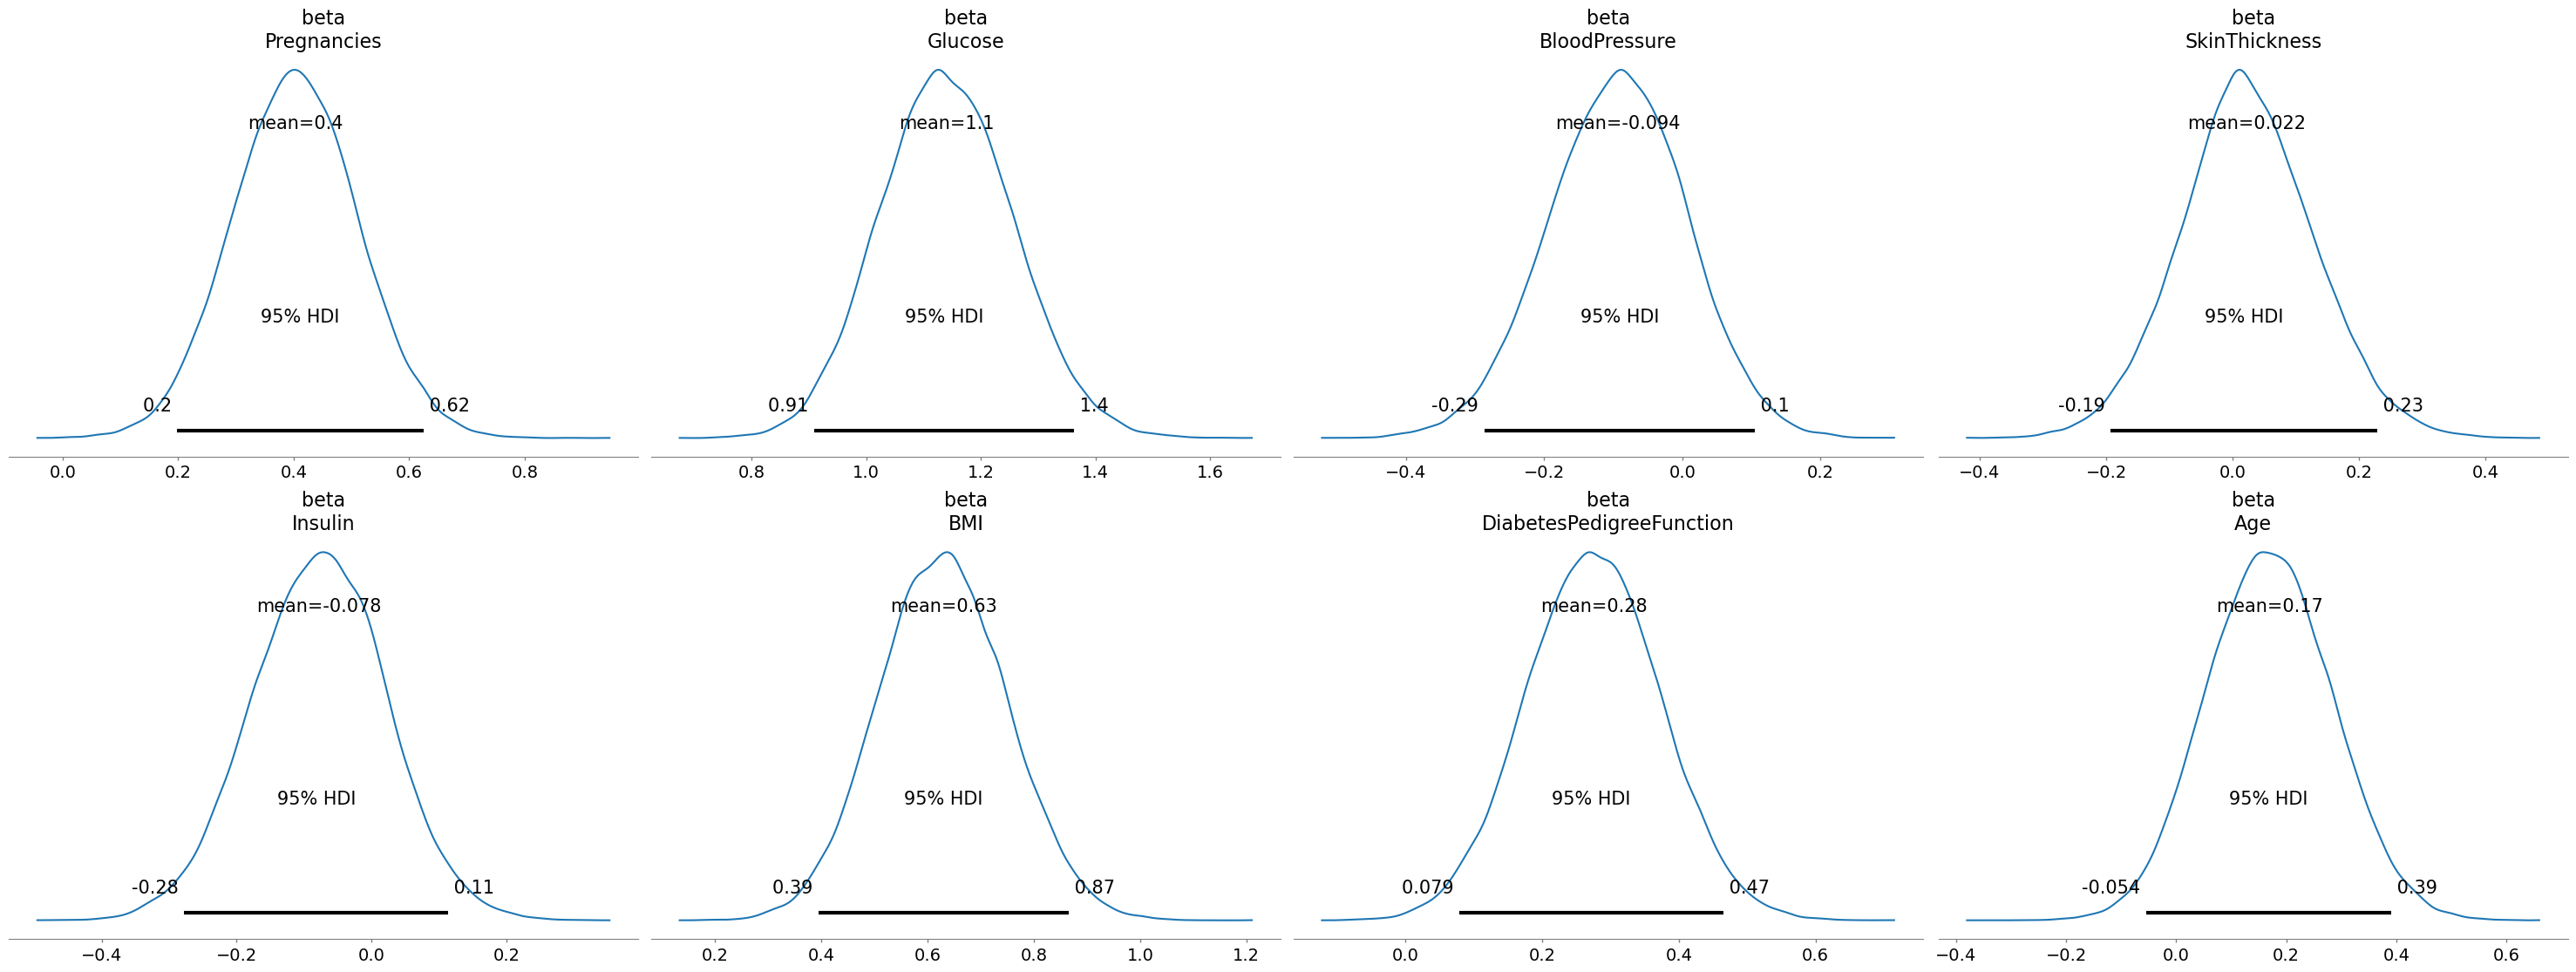

In [156]:
pm.plot_posterior(trace,var_names=["beta"], hdi_prob=0.95);

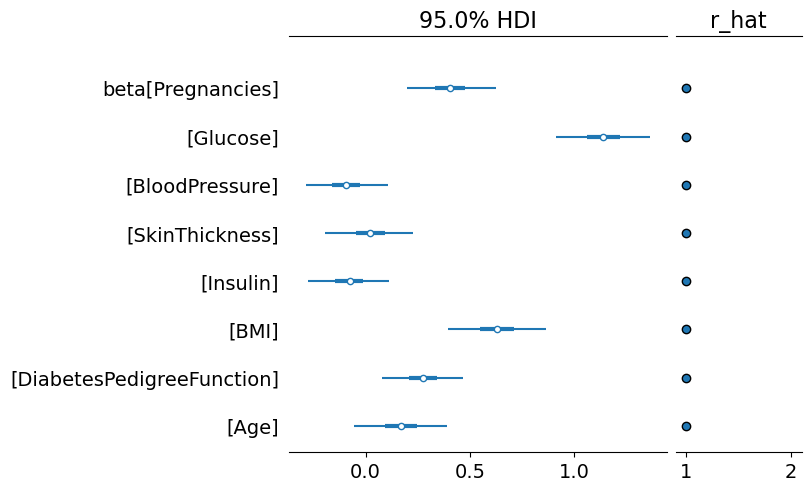

In [157]:
az.plot_forest(trace, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

# Inference 

### After seeing the plots and statistic above, we could see the beta parameters for SkinThickness are shrunken close to 0. Thus, for inference, we drop these two variables 

In [158]:
X = X.drop(columns=['SkinThickness'])
X.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639530,0.864997,-0.030631,0.555557,0.166288,0.468187,1.425067
1,-0.844335,-1.204712,-0.525841,-0.012698,-0.851573,-0.364823,-0.190548
2,1.233077,2.014836,-0.690912,-0.134254,-1.331422,0.604004,-0.105515
3,-0.844335,-1.073302,-0.525841,-0.727898,-0.633460,-0.920163,-1.040871
4,-1.141108,0.503620,-2.671755,0.103988,1.547672,5.481337,-0.020483


D:\anaconda3\envs\pymc_env\Lib\site-packages\pymc\data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


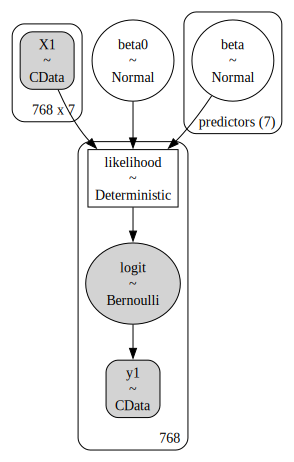

In [159]:
with pm.Model(coords={"predictors": X.columns.values}) as logistic_model:

    X1 = pm.MutableData("X1", X)
    y1 = pm.MutableData("y1", y)
    # intercept ~ normal(0,sd=100) - an uninformative prior
    beta0 = pm.Normal('beta0', 0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100, dims = "predictors")
   # beta2 = pymc.Laplace('beta1', mu=0, b=lambda_param)
   # beta3= pymc.Laplace('beta1', mu=0, b=lambda_param)

    # Transform random variables into vector of probabilities p(y_i=1)
    # according to logistic regression model specification.
    likelihood = pm.Deterministic("likelihood", pm.math.invlogit(beta0 + pm.math.dot(X1, beta)) )

    # Bernoulli random vector with probability of success
    # given by inverseee-logit function and actual data as observed
    pm.Bernoulli(name='logit', p=likelihood, observed=y1)
pm.model_to_graphviz(logistic_model)

In [160]:
# posterior sampling
with logistic_model:
    trace2 = pm.sample(10000, chains = 4, random_seed=2024, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta]


Output()

Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 39 seconds.


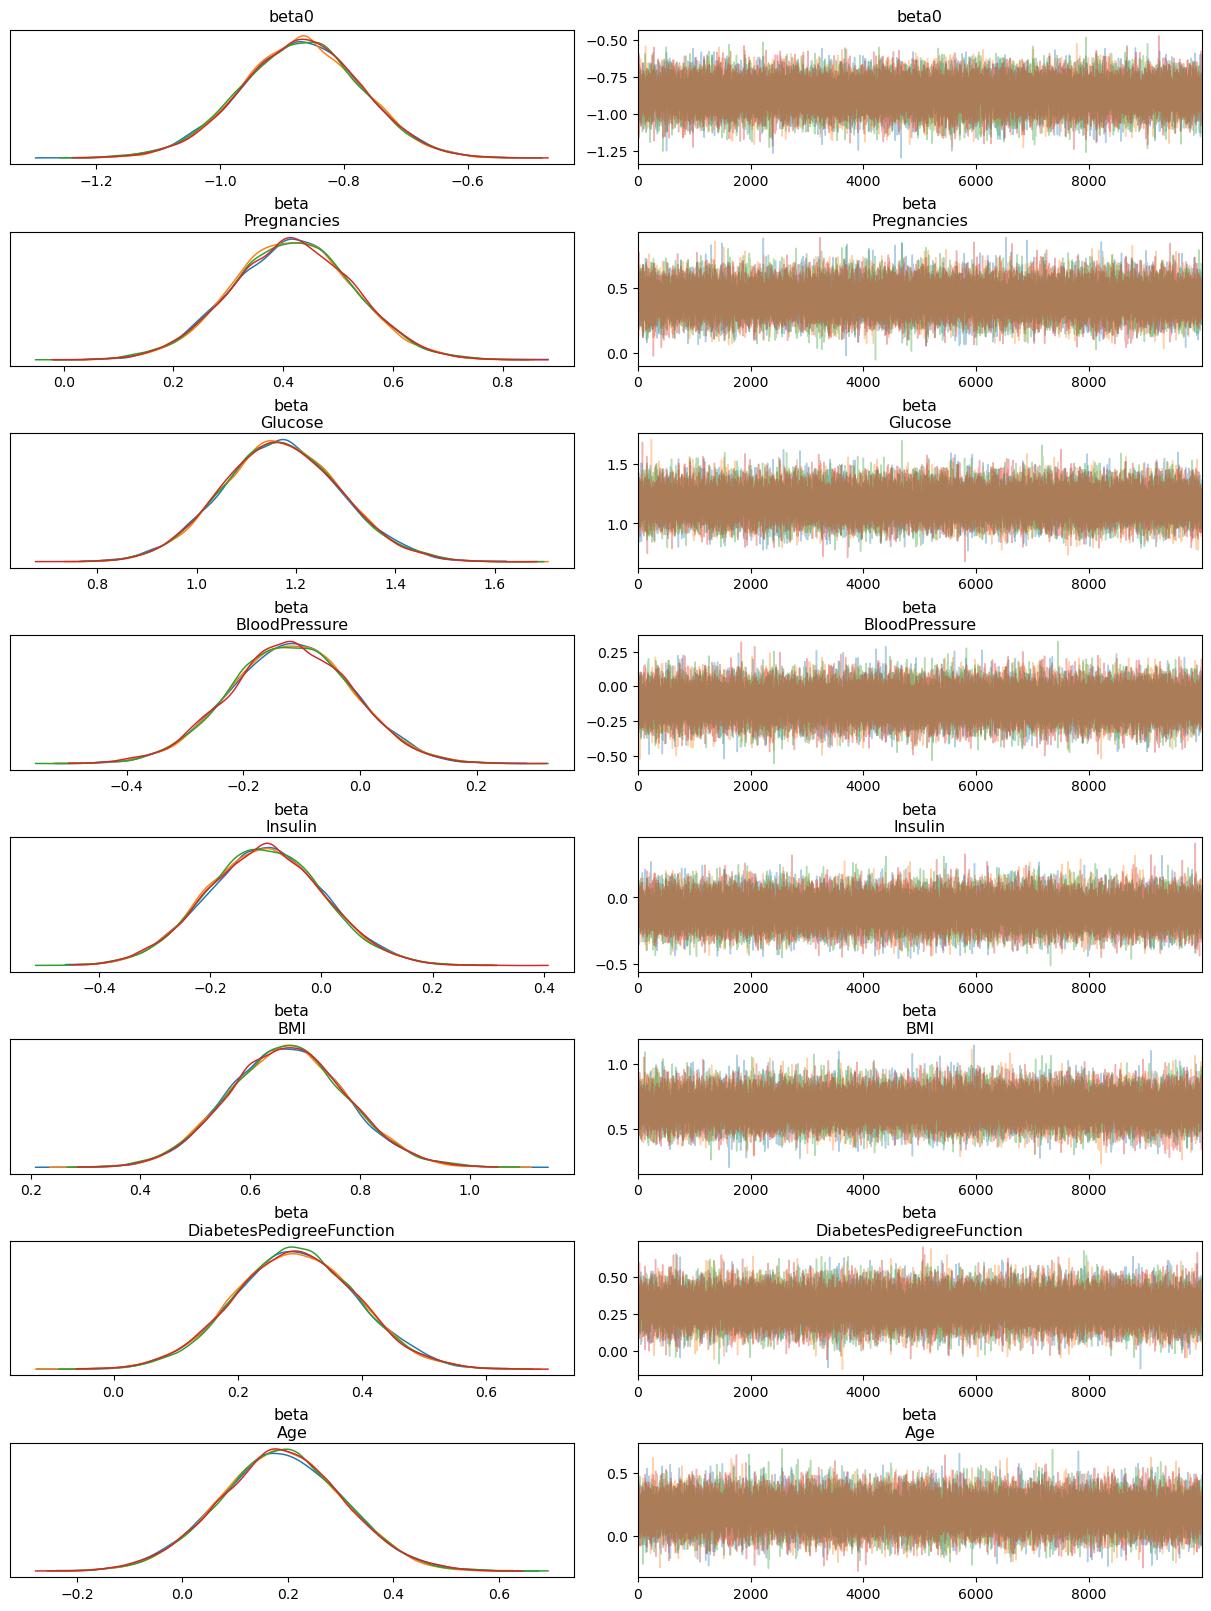

In [161]:
az.plot_trace(trace2, var_names=["beta0","beta"], compact=False)
plt.rcParams['figure.constrained_layout.use'] = True

In [170]:
az.summary(trace2, hdi_prob = 0.95, var_names=["beta0","beta"])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.869,0.098,-1.058,-0.675,0.000,0.0,48946.0,31268.0,1.0
beta[Pregnancies],0.417,0.111,0.198,0.633,0.001,0.0,43675.0,30866.0,1.0
beta[Glucose],1.170,0.119,0.936,1.405,0.001,0.0,47195.0,33577.0,1.0
beta[BloodPressure],-0.118,0.105,-0.317,0.090,0.000,0.0,49494.0,34493.0,1.0
beta[Insulin],-0.102,0.106,-0.307,0.109,0.001,0.0,44530.0,33126.0,1.0
beta[BMI],0.668,0.108,0.463,0.885,0.001,0.0,44952.0,31632.0,1.0
beta[DiabetesPedigreeFunction],0.293,0.099,0.097,0.485,0.000,0.0,51120.0,32088.0,1.0
beta[Age],0.187,0.118,-0.045,0.419,0.001,0.0,41381.0,31675.0,1.0


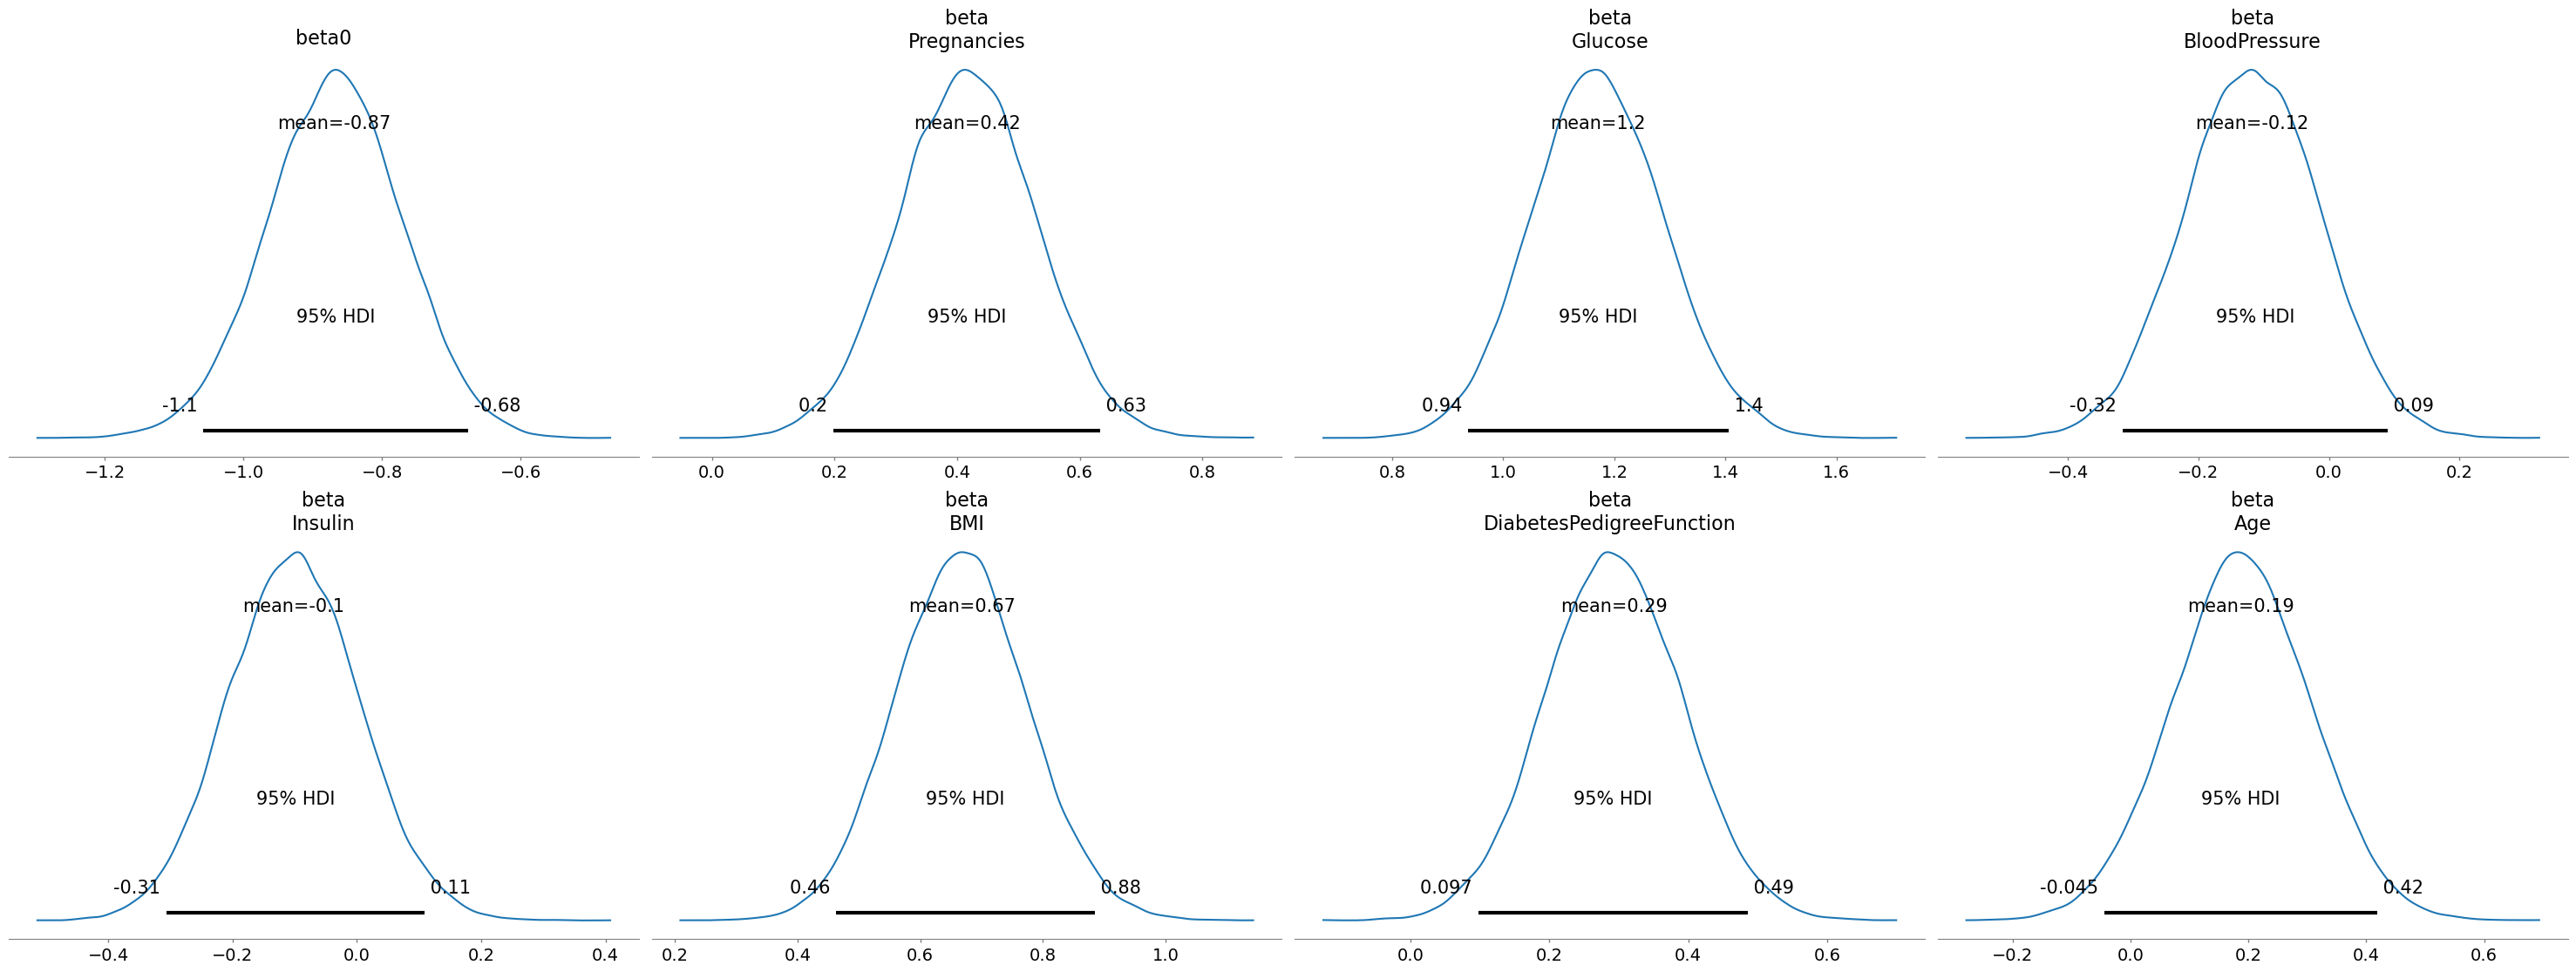

In [163]:
pm.plot_posterior(trace2,var_names=["beta0","beta"], hdi_prob=0.95);

## AUC and ROC 

In [164]:
y_score = np.mean(trace2.posterior.likelihood[0], axis=0)

In [165]:
logistic_model_prediction=[1 if x >0.5 else 0 for x in y_score]

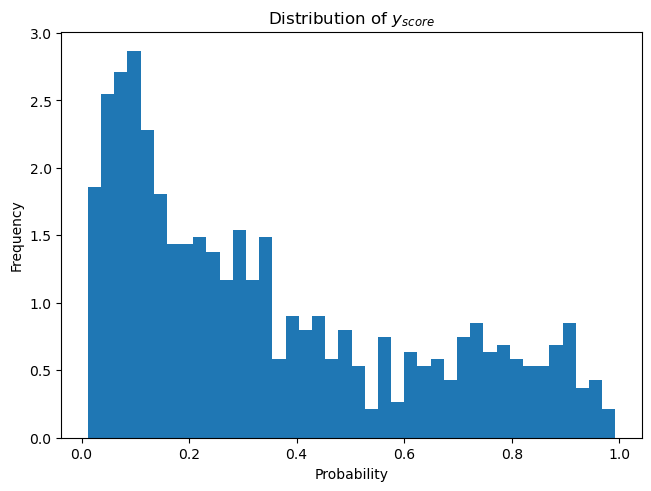

In [166]:

plt.hist(y_score, bins=40, density=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of $y_{score}$')
plt.show()

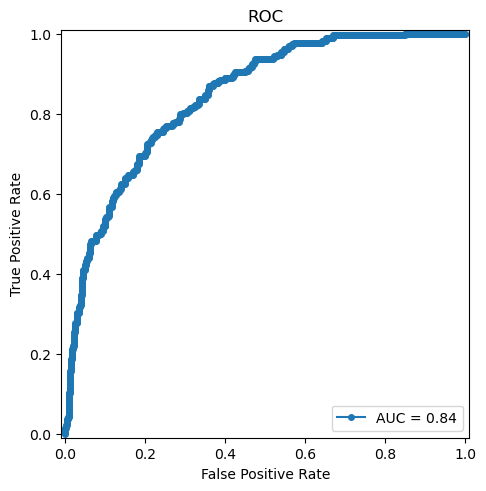

In [167]:
fpr, tpr, thresholds = roc_curve(
    y_true=y, y_score=y_score, pos_label=1, drop_intermediate=False
)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display = roc_display.plot(ax=ax, marker="o", markersize=4)
ax.set(title="ROC");

<Axes: >

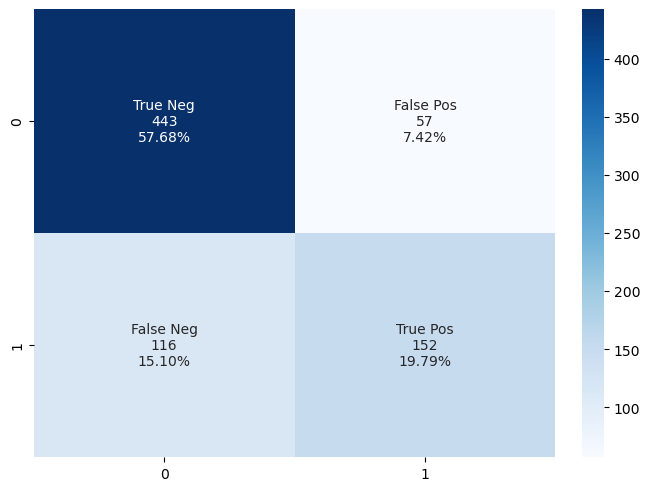

In [168]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y, logistic_model_prediction)
#print(cf_matrix)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

In [174]:
X.describe()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-7.864080e-17,5.782412e-16,1.873501e-16,-8.789266e-17,-6.013708e-16,2.451743e-16,2.035409e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.141108e+00,-2.551666e+00,-3.992318e+00,-1.627235e+00,-2.073007e+00,-1.188778e+00,-1.040871e+00
25%,-8.443348e-01,-7.201375e-01,-6.909118e-01,-4.557383e-01,-7.207051e-01,-6.885198e-01,-7.857741e-01
50%,-2.507887e-01,-1.534312e-01,-3.063053e-02,-1.628365e-01,-4.319676e-02,-2.999328e-01,-3.606124e-01
75%,6.395305e-01,6.103903e-01,6.296507e-01,2.728426e-01,6.025148e-01,4.659233e-01,6.597757e-01
max,3.904034e+00,2.540477e+00,4.096127e+00,7.725866e+00,5.037482e+00,5.879733e+00,4.061069e+00
